## 一、项目背景介绍
### 结核病是由结核杆菌感染引起的慢性传染病。结核菌可能侵入人体全身各种器官，但主要侵犯肺脏，称为肺结核病。结核病是青年人容易发生的一种慢性和缓发的传染病。潜伏期4～8周。其中80%发生在肺部，其他部位（颈淋巴、脑膜、腹膜、肠、皮肤、骨骼）也可继发感染。人与人之间呼吸道传播是本病传染的主要方式。传染源是接触排菌的肺结核患者。随着环境污染和艾滋病的传播，结核病发病率越发强烈。除少数发病急促外，临床上多呈慢性过程。常有低热、乏力等全身症状和咳嗽、咯血等呼吸系统表现。
### 我希望能够通过痰液的检测能够检测出结核杆菌的携带者并且能够早期对齐进行相关治疗，另外也能减少结核病的传播。并且痰液的收集相对来说也比较容易

## 二、数据介绍
### 数据说明
该数据集全部与结核有关，取自痰液样本。
它包含1265个痰液图像以及3734个细菌的边界框。XML文件包含图像的边界框详细信息。
### 数据来源
AI Research and Automated Laboratory Diagnostics

In [ ]:
#数据集解压缩
!unzip data/data83968/Tuberculosis6208.zip -d data/Tuberculosis

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


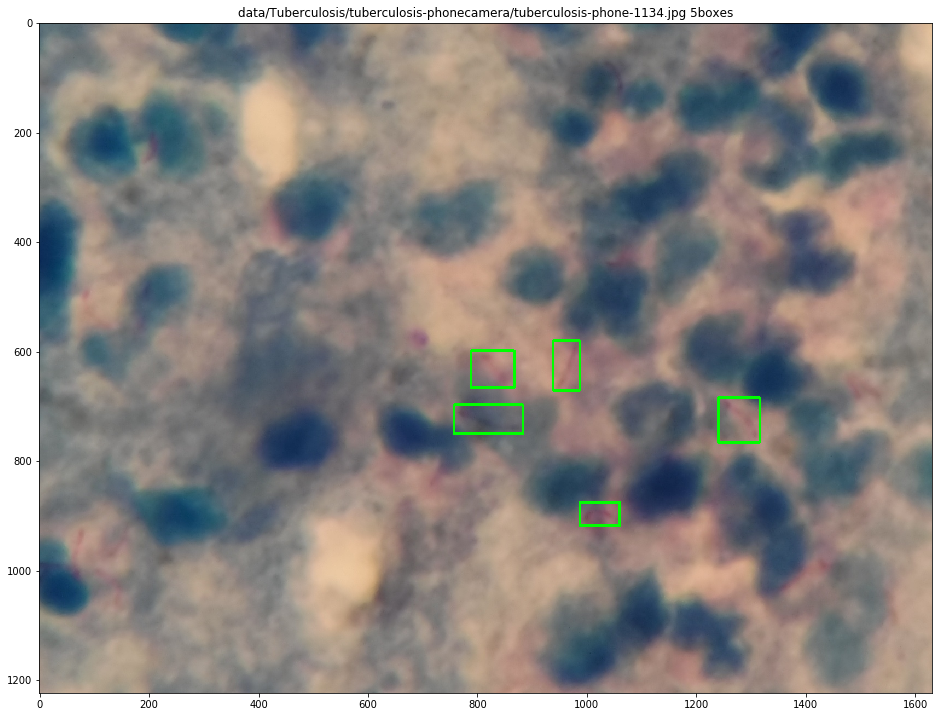

In [ ]:
#数据展示

import cv2
import matplotlib.pyplot as plt
from xml.dom.minidom import parse
import os
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

#读取标记框信息
def readbox(image,data_root):
    label=image.replace('.jpg','.xml')
    domtree=parse(os.path.join(data_root,label))
    labelinfo=domtree.documentElement
    boxlist=[]
    objects=labelinfo.getElementsByTagName('object')
    for obj in objects:
        boxinfo={}
        boxinfo['labelname']=obj.getElementsByTagName("label")[0].firstChild.data
        coordlist=["xmin","xmax","ymin","ymax"]
        for coord in coordlist:
            boxinfo[coord]=int(obj.getElementsByTagName(coord)[0].firstChild.data)
        boxlist.append(boxinfo)
    return boxlist

def showImgBox(image,boxlist):
    img=cv2.imread(image)
    for box in boxlist:
        boxname=box['labelname']
        box_xmin=box["xmin"]
        box_xmax=box['xmax']
        box_ymin=box['ymin']
        box_ymax=box['ymax']
        cv2.rectangle(img,(box_xmin,box_ymin),(box_xmax,box_ymax),(0, 255, 0), 4)

    plt.figure(figsize=(16, 16))
    plt.title(image+" "+str(len(boxlist))+"boxes")
    plt.imshow(img[:,:,::-1])
    plt.show()

def getboxclasses(data_root,image_list):
    boxnames=set()
    for index in range(len(image_list)):
        boxlist=readbox(image_list[index],data_root)
        for boxinfo in boxlist:
            boxnames.add(boxinfo['labelname'])
    return boxnames
data_root="data/Tuberculosis/tuberculosis-phonecamera"
image_list=[image for image in os.listdir(data_root) if image.endswith('.jpg')]

#这里改变index数值显示图像以及图像标注信息
index=2
showImgBox(os.path.join(data_root,image_list[index]),readbox(image_list[index],data_root))

## 三、模型介绍
这次项目主要用到了比较常规的yolov3模型。YOLO V3算法的基本思想可以分成两部分：

* 按一定规则在图片上产生一系列的候选区域，然后根据这些候选区域与图片上物体真实框之间的位置关系对候选区域进行标注。跟真实框足够接近的那些候选区域会被标注为正样本，同时将真实框的位置作为正样本的位置目标。偏离真实框较大的那些候选区域则会被标注为负样本，负样本不需要预测位置或者类别。
* 使用卷积神经网络提取图片特征并对候选区域的位置和类别进行预测。这样每个预测框就可以看成是一个样本，根据真实框相对它的位置和类别进行了标注而获得标签值，通过网络模型预测其位置和类别，将网络预测值和标签值进行比较，就可以建立起损失函数

### 产生候选区域

如何产生候选区域，是检测模型的核心设计方案。目前大多数基于卷积神经网络的模型所采用的方式大体如下：

* 按一定的规则在图片上生成一系列位置固定的锚框，将这些锚框看作是可能的候选区域，
* 对锚框是否包含目标物体进行预测，如果包含目标物体，还需要预测所包含物体的类别，以及预测框相对于锚框位置需要调整的幅度。


#### 生成锚框

将原始图片划分成$m\times n$个区域，如下图所示，原始图片高度H=640, 宽度W=480，如果我们选择小块区域的尺寸为$32 \times 32$，则m和n分别为：

$$m = \frac{640}{32} = 20$$

$$n = \frac{480}{32} = 15$$

#### 生成预测框

在前面已经指出，锚框的位置都是固定好的，不可能刚好跟物体边界框重合，需要在锚框的基础上进行位置的微调以生成预测框。预测框相对于锚框会有不同的中心位置和大小，采用什么方式能产生出在锚框上面微调得到的预测框呢，我们先来考虑如何生成其中心位置坐标。

比如上面图中在第10行第4列的小方块区域中心生成的一个锚框，如绿色虚线框所示。以小方格的宽度为单位长度，

此小方块区域左上角的位置坐标是：
$$c_x = 4$$
$$c_y = 10$$

此锚框的区域中心坐标是
$$center\_x = c_x + 0.5 = 4.5$$
$$center\_y = c_y + 0.5 = 10.5$$

可以通过下面的方式生成预测框的中心坐标：

$$b_x = c_x + \sigma(t_x)$$
$$b_y = c_y + \sigma(t_y)$$

其中$t_x$和$t_y$为实数，$\sigma(x)$是我们之前学过的Sigmoid函数，其定义如下：

$$\sigma(x) = \frac{1}{1 + exp(-x)}$$

由于Sigmoid的函数值总是在$0 \thicksim 1$之间，所以由上式计算出来的预测框中心点总是落在第十行第四列的小区域内部。

当$t_x=t_y=0$时，$b_x = c_x + 0.5$，$b_y = c_y + 0.5$，预测框中心与锚框中心重合，都是小区域的中心。

锚框的大小是预先设定好的，在模型中可以当作是超参数，下图中画出的锚框尺寸是

$$p_h = 350$$
$$p_w = 250$$

通过下面的公式生成预测框的大小：

$$b_h = p_h e^{t_h}$$
$$b_w = p_w e^{t_w}$$

如果$t_x=t_y=0, t_h=t_w=0$，则预测框跟锚框重合。

如果给$t_x, t_y, t_h, t_w$随机赋值如下：

$$t_x = 0.2,  t_y = 0.3, t_w = 0.1, t_h = -0.12$$

则可以得到预测框的坐标是(154.98, 357.44, 276.29, 310.42)

#### 对候选区域进行标注

每个在区域可以产生3种不同形状的锚框，每个锚框都是一个可能的候选区域，对这些候选区域我们希望知道这么几件事情：

- 锚框是否包含了物体，这可以看成是一个二分类问题，包含了物体和没有包含物体，我们使用标签objectness来表示。当锚框包含了物体时，objectness=1，表示预测框属于正类；当锚框不包含物体时，设置objectness=0，表示锚框属于负类。

- 如果锚框包含了物体，那么它对应的预测框的中心位置和大小应该是多少，或者说上面计算式中的$t_x, t_y, t_w, t_h$应该是多少。

- 如果锚框包含了物体，那么具体的具体类别是什么，这里使用变量label来表示其所属类别的标签。

现在对于任意一个锚框，我们需要对它进行标注，也就是需要确定其对应的objectness, $(t_x, t_y, t_w, t_h)$和label。


### 卷积神经网络提取特征


YOLO V3算法使用的骨干网络是Darknet53。Darknet53网络的具体结构如 **图16** 所示，在ImageNet图像分类任务上取得了很好的成绩。在检测任务中，将图中C0后面的平均池化、全连接层和Softmax去掉，保留从输入到C0部分的网络结构，作为检测模型的基础网络结构，也称为骨干网络。YOLO V3模型会在骨干网络的基础上，再添加检测相关的网络模块。

<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/d59dd9da1c494016accd40c8f0a72a9908f06c5d2d9b42c4aaad815c14d4c8a1" width = "400"></center>
<center><br>图16：Darknet53网络结构 </br></center>
<br></br>

下面的程序是Darknet53骨干网络的实现代码，这里将上图中C0、C1、C2所表示的输出数据取出，并查看它们的形状分别是，$C0 [1, 1024, 20, 20]$，$C1 [1, 512, 40, 40]$，$C2 [1, 256, 80, 80]$。

- 名词解释：特征图的步幅(stride)

在提取特征的过程中通常会使用步幅大于1的卷积或者池化，导致后面的特征图尺寸越来越小，特征图的步幅等于输入图片尺寸除以特征图尺寸。例如C0的尺寸是$20\times20$，原图尺寸是$640\times640$，则C0的步幅是$\frac{640}{20}=32$。同理，C1的步幅是16，C2的步幅是8。

### 根据输出特征图计算预测框位置和类别

YOLO-V3中对每个预测框计算逻辑如下：

- 预测框是否包含物体。也可理解为objectness=1的概率是多少，可以用网络输出一个实数x，可以用Sigmoid(x)表示objectness为正的概率$P_{obj}$

- 预测物体位置和形状。物体位置和形状$t_x, t_y, t_w, t_h$可以用网络输出4个实数来表示$t_x, t_y, t_w, t_h$

- 预测物体类别。预测图像中物体的具体类别是什么，或者说其属于每个类别的概率分别是多少。总的类别数为C，需要预测物体属于每个类别的概率$(P_1, P_2, ..., P_C)$，可以用网络输出C个实数$(x_1, x_2, ..., x_C)$，对每个实数分别求Sigmoid函数，让$P_i = Sigmoid(x_i)$，则可以表示出物体属于每个类别的概率。


对于一个预测框，网络需要输出$(5 + C)$个实数来表征它是否包含物体、位置和形状尺寸以及属于每个类别的概率。

由于我们在每个小方块区域都生成了K个预测框，则所有预测框一共需要网络输出的预测值数目是：

$$[K(5 + C)] \times m \times n $$

还有更重要的一点是网络输出必须要能区分出小方块区域的位置来，不能直接将特征图连接一个输出大小为$[K(5 + C)] \times m \times n$的全连接层。

### 建立输出特征图与预测框之间的关联

现在观察特征图，经过多次卷积核池化之后，其步幅stride=32，$640 \times 480$大小的输入图片变成了$20\times15$的特征图；而小方块区域的数目正好是$20\times15$，也就是说可以让特征图上每个像素点分别跟原图上一个小方块区域对应。这也是为什么我们最开始将小方块区域的尺寸设置为32的原因，这样可以巧妙的将小方块区域跟特征图上的像素点对应起来，解决了空间位置的对应关系。

<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/93e251bb309b4bb7a2031466ac62647089dbb280f2e84d5aaa468a9944f4654c" width = "400"></center>
<center><br>图17：特征图C0与小方块区域形状对比 </br></center>
<br></br>

下面需要将像素点$(i,j)$与第i行第j列的小方块区域所需要的预测值关联起来，每个小方块区域产生K个预测框，每个预测框需要$(5 + C)$个实数预测值，则每个像素点相对应的要有$K(5 + C)$个实数。为了解决这一问题，对特征图进行多次卷积，并将最终的输出通道数设置为$K(5 + C)$，即可将生成的特征图与每个预测框所需要的预测值巧妙的对应起来。

### 多尺度检测

目前我们计算损失函数是在特征图P0的基础上进行的，它的步幅stride=32。特征图的尺寸比较小，像素点数目比较少，每个像素点的感受野很大，具有非常丰富的高层级语义信息，可能比较容易检测到较大的目标。为了能够检测到尺寸较小的那些目标，需要在尺寸较大的特征图上面建立预测输出。如果我们在C2或者C1这种层级的特征图上直接产生预测输出，可能面临新的问题，它们没有经过充分的特征提取，像素点包含的语义信息不够丰富，有可能难以提取到有效的特征模式。在目标检测中，解决这一问题的方式是，将高层级的特征图尺寸放大之后跟低层级的特征图进行融合，得到的新特征图既能包含丰富的语义信息，又具有较多的像素点，能够描述更加精细的结构。

具体的网络实现方式如 **图19** 所示：

<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/1ec38428c95d4ab4a133dd4262f130eddeee0befa6dd40f599b9ce562f442685" width = "800"></center>
<center><br>图19：生成多层级的输出特征图P0、P1、P2 </br></center>
<br></br>

YOLO-V3在每个区域的中心位置产生3个锚框，在3个层级的特征图上产生锚框的大小分别为P2 [(10×13),(16×30),(33×23)]，P1 [(30×61),(62×45),(59× 119)]，P0[(116 × 90), (156 × 198), (373 × 326]。越往后的特征图上用到的锚框尺寸也越大，能捕捉到大尺寸目标的信息；越往前的特征图上锚框尺寸越小，能捕捉到小尺寸目标的信息。



## 四、模型训练
模型训练飞桨为我们提供了paddledetetion套件

In [ ]:
!git clone https://gitee.com/PaddlePaddle/PaddleDetection.git


Cloning into 'PaddleDetection'...
remote: Enumerating objects: 21396, done.
remote: Counting objects: 100% (1866/1866), done.
remote: Compressing objects: 100% (934/934), done.
remote: Total 21396 (delta 1315), reused 1300 (delta 929), pack-reused 19530
Receiving objects: 100% (21396/21396), 202.22 MiB | 14.66 MiB/s, done.
Resolving deltas: 100% (15864/15864), done.
Checking connectivity... done.


In [ ]:
%cd /home/aistudio/PaddleDetection
!pip install -r requirements.txt
! python setup.py install
%cd /home/aistudio/PaddleDetection
! python ppdet/modeling/tests/test_architectures.py
# 在GPU上预测一张图片
!export CUDA_VISIBLE_DEVICES=0
!python tools/infer.py -c configs/ppyolo/ppyolo_r50vd_dcn_1x_coco.yml -o use_gpu=true weights=https://paddledet.bj.bcebos.com/models/ppyolo_r50vd_dcn_1x_coco.pdparams --infer_img=demo/000000014439.jpg

### 将数据转换成标准的voc数据格式

处理教程：[https://github.com/PaddlePaddle/PaddleDetection/blob/release/2.3/docs/tutorials/PrepareDataSet.md](https://github.com/PaddlePaddle/PaddleDetection/blob/release/2.3/docs/tutorials/PrepareDataSet.md)

用户数据集转成VOC数据后目录结构如下（注意数据集中路径名、文件名尽量不要使用中文，避免中文编码问题导致出错）：

```
dataset/xxx/
├── annotations
│   ├── xxx1.xml
│   ├── xxx2.xml
│   ├── xxx3.xml
│   |   ...
├── images
│   ├── xxx1.jpg
│   ├── xxx2.jpg
│   ├── xxx3.jpg
│   |   ...
├── label_list.txt (必须提供，且文件名称必须是label_list.txt )
├── train.txt (训练数据集文件列表, ./images/xxx1.jpg ./annotations/xxx1.xml)
└── valid.txt (测试数据集文件列表)
```

In [ ]:
%cd /home/aistudio/
!mkdir dataset
!mkdir dataset/Tuberculosis/
!mkdir dataset/Tuberculosis/pre_annotations
!mkdir dataset/Tuberculosis/images
!cp data/Tuberculosis/tuberculosis-phonecamera/*.jpg dataset/Tuberculosis/images/
!cp data/Tuberculosis/tuberculosis-phonecamera/*.xml dataset/Tuberculosis/pre_annotations/
!mkdir dataset/Tuberculosis/annotations

/home/aistudio


In [ ]:
%cd /home/aistudio/
#将xml文件转换为标准的voc格式
import os
from xml.dom import minidom
from xml.dom.minidom import parse
import xml.etree.cElementTree as ET
from PIL import Image

ann_path="./dataset/Tuberculosis/annotations"
img_path='./dataset/Tuberculosis/images/'
pre_path='./dataset/Tuberculosis/pre_annotations/'



def formatter(elem):
    """Return a pretty-printed XML string for the Element.
    """
    rough_string = ET.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="    ")

def create_root(file_prefix, width, height):
    root = ET.Element("annotation")
    ET.SubElement(root, "filename").text = "{}.jpg".format(file_prefix)
    size = ET.SubElement(root, "size")
    ET.SubElement(size, "width").text = str(width)
    ET.SubElement(size, "height").text = str(height)
    ET.SubElement(size, "depth").text = "3"
    return root

def create_object_annotation(root, voc_labels):
    for voc_label in voc_labels:
        obj = ET.SubElement(root, "object")
        ET.SubElement(obj, "name").text = voc_label[0]
        bbox = ET.SubElement(obj, "bndbox")
        ET.SubElement(bbox, "xmin").text = str(voc_label[1])
        ET.SubElement(bbox, "ymin").text = str(voc_label[2])
        ET.SubElement(bbox, "xmax").text = str(voc_label[3])
        ET.SubElement(bbox, "ymax").text = str(voc_label[4])
    return root

def create_file(file_prefix, width, height, voc_labels):
    root = create_root(file_prefix, width, height)
    root = create_object_annotation(root, voc_labels)
    with open("{}/{}.xml".format(ann_path, file_prefix), "w") as f:

            f.write(formatter(root))
            f.close()

for image_name in os.listdir(img_path):
    label=image_name.replace('.jpg','.xml')
    img = Image.open(os.path.join(img_path,image_name))
    w,h=img.size
    voc_labels = []
    domtree=parse(os.path.join(pre_path,label))
    labelinfo=domtree.documentElement
    objects=labelinfo.getElementsByTagName('object')
    for obj in objects:
        voc = []
        voc.append(obj.getElementsByTagName("label")[0].firstChild.data)
        coordlist=["xmin","ymin","xmax","ymax"]
        for coord in coordlist:
            voc.append(int(obj.getElementsByTagName(coord)[0].firstChild.data))
        voc_labels.append(voc)
    create_file(image_name[:-4], w, h, voc_labels)

/home/aistudio


In [ ]:
with open('./dataset/Tuberculosis/label_list.txt', 'w') as up:
    up.write('TBbacillus\n')

import os

filenames=os.listdir('./dataset/Tuberculosis/images/')
train_rate=0.8
split_num=int(train_rate*len(filenames))
with open('./dataset/Tuberculosis/train.txt', 'w') as up:
    for filename in filenames[:split_num]:
        filename=filename[:-4]
        up.write(f"images/{filename}.jpg annotations/{filename}.xml\n")

with open('./dataset/Tuberculosis/valid.txt', 'w') as up:
    for filename in filenames[split_num:]:
        filename=filename[:-4]
        up.write(f"images/{filename}.jpg annotations/{filename}.xml\n")

### 模型训练

1. 从`/home/aistudio/PaddleDetection/configs/`目录中找到想要的模型，这里使用VOC标注，则只能用VOC模型。
2. 若使用`yolov3/yolov3_mobilenet_v1_270e_voc.yml`， 则需要修改两个文件：

`datasets/voc.yml`：具体的数据集路径；
    
```
metric: VOC
map_type: 11point
num_classes: 1

TrainDataset:
  !VOCDataSet
    dataset_dir: /home/aistudio/dataset/Tuberculosis
    anno_path: train.txt
    label_list: label_list.txt
    data_fields: ['image', 'gt_bbox', 'gt_class', 'difficult']

EvalDataset:
  !VOCDataSet
    dataset_dir: /home/aistudio/dataset/Tuberculosis
    anno_path: valid.txt
    label_list: label_list.txt
    data_fields: ['image', 'gt_bbox', 'gt_class', 'difficult']

TestDataset:
  !ImageFolder
    anno_path: /home/aistudio/dataset/Tuberculosis/label_list.txt

```
    
   
`yolov3/yolov3_mobilenet_v1_270e_voc.yml`：Epoch个数、学习率等
    
```
_BASE_: [
  '../datasets/voc.yml',
  '../runtime.yml',
  '_base_/optimizer_270e.yml',
  '_base_/yolov3_mobilenet_v1.yml',
  '_base_/yolov3_reader.yml',
]

snapshot_epoch: 5
weights: output/yolov3_mobilenet_v1_270e_voc/59

# set collate_batch to false because ground-truth info is needed
# on voc dataset and should not collate data in batch when batch size
# is larger than 1.
EvalReader:
  collate_batch: false

LearningRate:
  base_lr: 0.001
  schedulers:
  - !PiecewiseDecay
    gamma: 0.1
    milestones:
    - 216
    - 243
  - !LinearWarmup
    start_factor: 0.
    steps: 1000

```

In [9]:
#开始训练
! cd PaddleDetection && python tools/train.py -c /home/aistudio/PaddleDetection/configs/yolov3/yolov3_mobilenet_v1_270e_voc.yml

W0227 11:03:59.996894   602 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.0, Runtime API Version: 10.1
W0227 11:04:00.002151   602 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[02/27 11:04:02] ppdet.utils.download INFO: Downloading MobileNetV1_pretrained.pdparams from https://paddledet.bj.bcebos.com/models/pretrained/MobileNetV1_pretrained.pdparams
100%|██████████████████████████████████| 12628/12628 [00:00<00:00, 63984.74KB/s]
[02/27 11:04:02] ppdet.utils.checkpoint INFO: Finish loading model weights: /home/aistudio/.cache/paddle/weights/MobileNetV1_pretrained.pdparams
[02/27 11:04:03] ppdet.engine INFO: Epoch: [0] [  0/121] learning_rate: 0.000000 loss_xy: 20.329687 loss_wh: 31.339081 loss_obj: 13332.324219 loss_cls: 6.370192 loss: 13390.363281 eta: 14:25:47 batch_cost: 1.5901 data_cost: 1.4373 ips: 5.0312 images/s
[02/27 11:04:36] ppdet.engine INFO: Epoch: [0] [ 20/121] learning_rate: 0.000020 loss_xy: 23.648916 loss_wh: 

### 模型验证（这里模型使用当中训练了差不多的模型进行验证模型文件训练好后再paddledetection的output下，读者也可以自己根据喜好去更改yml文件中的weight配置）

In [10]:
%cd /home/aistudio/
! cd PaddleDetection && python tools/eval.py -c /home/aistudio/PaddleDetection/configs/yolov3/yolov3_mobilenet_v1_270e_voc.yml

/home/aistudio
W0227 11:14:30.960119   785 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.0, Runtime API Version: 10.1
W0227 11:14:30.965523   785 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[02/27 11:14:33] ppdet.utils.checkpoint INFO: Finish loading model weights: output/yolov3_mobilenet_v1_270e_voc/59.pdparams
[02/27 11:14:33] ppdet.engine INFO: Eval iter: 0
[02/27 11:14:35] ppdet.engine INFO: Eval iter: 100
[02/27 11:14:38] ppdet.engine INFO: Eval iter: 200
[02/27 11:14:39] ppdet.metrics.metrics INFO: Accumulating evaluatation results...
[02/27 11:14:39] ppdet.metrics.metrics INFO: mAP(0.50, 11point) = 73.84%
[02/27 11:14:39] ppdet.engine INFO: Total sample number: 244, averge FPS: 39.642682372150524


### 可视化模型效果

In [ ]:
%cd /home/aistudio/
! cd PaddleDetection && python tools/infer.py -c /home/aistudio/PaddleDetection/configs/yolov3/yolov3_mobilenet_v1_270e_voc.yml --infer_dir=/home/aistudio/dataset/Tuberculosis/images/ --save_txt=True --output_dir=/home/aistudio/test_result/ > log.log

/home/aistudio
W0227 11:15:33.672405   894 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.0, Runtime API Version: 10.1
W0227 11:15:33.677943   894 device_context.cc:465] device: 0, cuDNN Version: 7.6.


In [ ]:
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from xml.dom.minidom import parse
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
result_root='/home/aistudio/test_result'
result_list_jpg=[filename for filename in os.listdir(result_root) if filename.endswith(".jpg")]
show_index=0
img = Image.open(os.path.join(result_root,result_list_jpg[show_index]))
plt.figure("Image") # 图像窗口名称
plt.figure(figsize=(16, 16))
plt.imshow(img)
plt.axis('on') # 关掉坐标轴为 off
plt.title('image') # 图像题目
plt.show()

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 